# Set up

## Purpose
- first have to make arm
- with qdotdot, simulate arm (show traj/gif)
- optionally, extract qdotdot using DMPs (through MATLAB)

In [1]:
import numpy as np

from matplotlib import pyplot as plt

# Kinematic Simulation for N-Link Planar Arm Reach Task Using PDFF and DMPs
We can take input of $\ddot{q}$ or also DMP class object with basis centers and $\Theta$ param matrix
Some simple maths show and do in code.

In [7]:
class RobotArm2D:
    def __init__(self, n_dims = 2, arm_length = 0.8, rel_link_lengths = np.array([1.5, 1.25, 0.4, 0.15, 0.15, 0.1])):
        self.n_dims = n_dims
        self.arm_length = arm_length
        self.link_lengths = arm_length/sum(rel_link_lengths) * rel_link_lengths[0:n_dims+1]

    def get_arm_params(self):
        return self.n_dims, self.arm_length, self.link_lengths

In [8]:
def get_traj(qdotdot, robot_arm, dt = 0.05, init_condit = [None, None]):
    """Takes in a joint accelerations qdotdot, and return 
    
    Keyword arguments:
    argument -- qdotdot: an t x n_dim matrix (t timesteps, n_dim dimensions) (numpy array)
    Return: return_description
    """
    
    n_time_steps = qdotdot.shape[0]
    n_dims_qdotdot = qdotdot.shape[1] if qdotdot.ndim > 1 else 1

    n_dims, arm_length, link_lengths = robot_arm.get_arm_params()
    assert(n_dims == n_dims_qdotdot)

    time_steps = dt * np.arange(n_time_steps)
    q = np.zeros((n_time_steps, n_dims))
    qdot = np.zeros((n_time_steps, n_dims))
    
    if init_condit is not None:
        q0, qdot0 = init_condit[0], init_condit[1]
        assert(qdot.shape[1] == len(qdot0))
        qdot[0, :] = qdot0
        q[0, :] = q0
    else:
        # if None, then assume 0 init conditions
        pass
    
    if qdotdot.ndim > 1:
        for i in range(1, n_time_steps):
            qdot[i, :] = qdot[i-1, :] + dt*qdotdot[i, :]
            q[i, :] = q[i-1, :] + dt*qdot[i, :]
    else:
        for i in range(1, n_time_steps):
            qdot[i] = qdot[i-1] + dt*qdotdot[i]
            q[i] = q[i-1] + dt*qdot[i]
        
    # Could use np.trapez but it gave me some weird error
    # qdot[:,0] = np.trapez(qdotdot, x = time_steps)     
    # https://docs.scipy.org/doc/scipy/reference/tutorial/integrate.html

    return time_steps, q, qdot, qdotdot



In [ ]:
# necessary code/items for robotic arm structures/classes

"""
2D/Planar class only needs:
    task.n_dims = n_dofs;
    task.arm_length = arm_length;
    task.link_lengths = getlinklengths(arm_type,n_dims,arm_length);
    For sub DMP class:
      n_basis_functions_per_dim
      intersection_height_ = intersection_height
      centers_ = None
      widths_ = None

3D class can stay unimplemented for now.

% default arm length for humans: ~0.8m; 6 dofs (shoulder to tip of index finder)
  
% Approximate relative human arm lengths
% http://www.paintdrawpaint.com/2011/01/drawing-basics-proportions-of-arm.html
rel_link_lengths_human = [1.5 1.25 0.4 0.15 0.15 0.1];

% Convert relative link lengths to absolute values
link_lengths = arm_length*rel_link_lengths_human/sum(rel_link_lengths_human);

% Choose only first 'n_dofs' degrees of freedom
  link_lengths = link_lengths(1:n_dofs);
"""

## Creating test data

2 joints; each with a sinusoidal movement

In [9]:
# Each joint has sinusoidal movement
# base frequency
omega = 1
multi_factor = 5 # each joint rotates 5 times faster
n_time_steps = 1001
dt = 0.005
time_steps = dt * np.arange(n_time_steps)

n_dims = 2
qdotdot = np.zeros((n_time_steps, n_dims))

# This is the first joint (base joint)
qdotdot[:,0] = (10)*np.sin(2*np.pi*omega*time_steps) 

# This is the second joint
qdotdot[:,1] = (10)*np.sin(2*np.pi*multi_factor*omega*time_steps)

q0 = [0, 0]
qdot0 = [-10/(2*np.pi*omega), -10/(2*np.pi*multi_factor*omega)]
init_condit = [q0, qdot0]


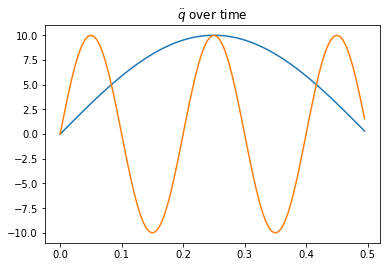

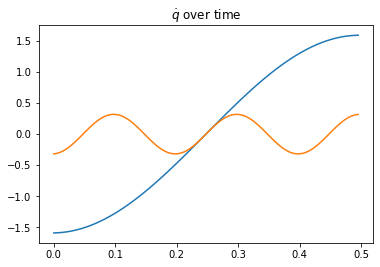

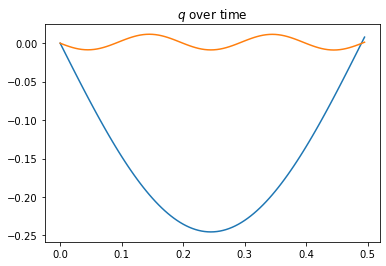

In [10]:
robot_arm = RobotArm2D(n_dims = n_dims) # by default takes two joints

time_steps, q, qdot, qdotdot = get_traj( qdotdot, robot_arm, init_condit = [ q0, qdot0 ], dt = dt)
pts_to_trace = 100

plt.figure()
plt.title('$\ddot{q}$ over time')
plt.plot(time_steps[:pts_to_trace], qdotdot[:pts_to_trace, 0])
plt.plot(time_steps[:pts_to_trace], qdotdot[:pts_to_trace, 1])

plt.figure()
plt.title('$\dot{q}$ over time')
plt.plot(time_steps[:pts_to_trace], qdot[:pts_to_trace, 0])
plt.plot(time_steps[:pts_to_trace], qdot[:pts_to_trace, 1])

plt.figure()
plt.title('$q$ over time')
plt.plot(time_steps[:pts_to_trace], q[:pts_to_trace, 0])
plt.plot(time_steps[:pts_to_trace], q[:pts_to_trace, 1])


In [ ]:
# code for getting angles by integrating qdd or DMP policy over time

'''
function [trajectory (or angles in our case)] = linearpolicyintegrate(activations,theta,dt)

n_dim = size(theta,1);
n_timesteps = size(activations,1);

ydd = zeros(n_timesteps,n_dim);
yd = ydd;
y = ydd;
ts = dt*(0:n_timesteps-1)';

for i_dim=1:n_dim
  % Compute acceleration from basis functions
  ydd(:,i_dim) = sum(repmat(theta(i_dim,:),n_timesteps,1).*activations,2);

  % or this:
  % Compute sum(phi*wi)/sum(phi)
  weighted_sum_activations = sum(activations.*repmat(theta,T,1),2);
  sum_activations = sum(activations,2);
  f = (weighted_sum_activations./sum_activations).*vs;

  % Integrate to get velocity and position over time.
  for tt=2:n_timesteps
    yd(tt,i_dim)  = yd(tt-1,i_dim) + dt*ydd(tt,i_dim);
    y(tt,i_dim)   = y(tt-1,i_dim)  + dt*yd(tt,i_dim);
  end
end


trajectory.ts = ts;
trajectory.y = y;
trajectory.yd = yd;
trajectory.ydd = ydd;

%% normalized version (python)
% [https://github.com/stulp/dmpbbo/blob/ca900e3b851d25faaf59ea296650370c70ed7d0f/python/functionapproximators/BasisFunction.py#L22]
% question asked here: [https://github.com/stulp/dmpbbo/issues/58#issuecomment-981094163]

if (normalized_basis_functions):
            # Normalize the basis value; they should sum to 1.0 for each time step.
            for i_sample in range(n_samples):
                sum_kernel_activations = kernel_activations[i_sample,:].sum()
                for i_basis in range(n_basis_functions):
                    if (sum_kernel_activations==0.0):
                        # Apparently, no basis function was active. Set all to same value
                        kernel_activations[i_sample,i_basis] = 1.0/n_basis_functions
                    else:
                        # Standard case, normalize so that they sum to 1.0
                        kernel_activations[i_sample,i_basis] /= sum_kernel_activations
'''

# the DMP policy class needs at least this information
''' 
n_basis_functions_per_dim = 10;
time = 2;
dt = 1/100;
n_timesteps = ceil(time/dt);
ts = dt*(0:n_timesteps-1)';
widths = (0.4*time/n_basis_functions)*ones(1,n_basis_functions);   % variance
centers = linspace(4*widths(1),time-4*widths(1),n_basis_functions);
activations = basisfunctionactivations(centers,widths,ts); % normalized weighted sum

theta = randn(2,n_basis_functions);

trajectory = linearpolicyintegrate(activations,theta,dt);
'''

In [11]:
def angles_to_link_positions_2D(q, robot_arm):
    n_time_steps = q.shape[0]
    n_dims = q.shape[1]
    
    n_dims_robot, arm_length, link_lengths = robot_arm.get_arm_params()
    assert(n_dims == n_dims_robot)
    
    
    links_x = np.zeros((n_time_steps, n_dims+1))
    links_y = np.zeros((n_time_steps, n_dims+1))
    
    for t in range(n_time_steps):
        sum_angles = 0
        
        for i_dim in range(n_dims):
            sum_angles += q[t, i_dim]
            links_x[t, i_dim + 1] = links_x[t, i_dim] + np.cos(sum_angles) * link_lengths[i_dim]
            links_y[t, i_dim + 1] = links_y[t, i_dim] + np.sin(sum_angles) * link_lengths[i_dim]
            
    link_positions = np.zeros((n_time_steps, 2*(n_dims+1)))
    # desired structure of link positions is x y x y x y 
    # (first x y are for the base joint)
    for n in range(n_dims + 1):
        link_positions[:, 2*n] = links_x[:,n]
        link_positions[:, 2*n+1] = links_y[:,n]
    
    return link_positions

In [12]:
# forward kinematics
link_positions = angles_to_link_positions_2D(q, robot_arm)

In [58]:
print(link_positions[:,1])

[0. 0. 0. ... 0. 0. 0.]


<IPython.core.display.Javascript object>


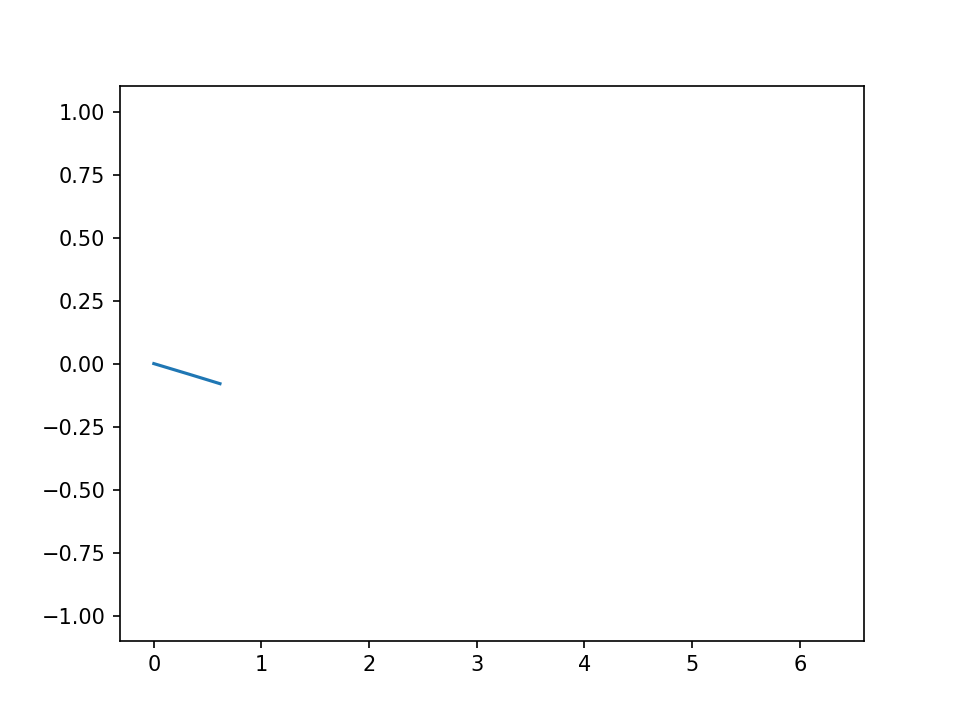

In [22]:
%matplotlib notebook
import matplotlib.animation

fig, ax = plt.subplots()
l, = ax.plot([0,2*np.pi],[-1,1])

animate = lambda i: l.set_data(
    [link_positions[i, 0], link_positions[i, 2], link_positions[i, 4]], 
    [link_positions[i, 1], link_positions[i, 3], link_positions[i, 5]]
)

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(time_steps))

plt.show()

In [ ]:
# code for (planar, n-link) arm pos given joint angles
'''
void TaskSolverDmpArm2D::anglesToLinkPositions(const MatrixXd& angles, MatrixXd& link_positions) const
{
  int n_time_steps = angles.rows();
  int n_dofs = angles.cols();
  MatrixXd links_x = MatrixXd::Zero(n_time_steps_,n_dofs+1);
  MatrixXd links_y = MatrixXd::Zero(n_time_steps_,n_dofs+1);
  for (int tt=0; tt<n_time_steps_; tt++)
  {
    double sum_angles = 0.0;
    for (int i_dof=0; i_dof<n_dofs; i_dof++)
    {
      sum_angles = sum_angles + angles(tt,i_dof);
      links_x(tt,i_dof+1) = links_x(tt,i_dof) + cos(sum_angles)*link_lengths_(i_dof);
      links_y(tt,i_dof+1) = links_y(tt,i_dof) + sin(sum_angles)*link_lengths_(i_dof);
    }
  }
  
  // x y x y x y
  link_positions.resize(n_time_steps,2*(n_dofs+1));
  for (int i_link=0; i_link<n_dofs+1; i_link++)
  {
    link_positions.col(2*i_link+0) = links_x.col(i_link);
    link_positions.col(2*i_link+1) = links_y.col(i_link);
  }
}
'''

In [9]:
# code for 2D animation or plot display of the reach task
#   1. should be able to take a goal point and display it (as star/dot)
#   2. work/plot for N-DOF planar
#   3. show radius for reach task completion tolerance
#   4. animate movement for the range of angles (show similar to gifs/anims here: https://github.com/pranshumalik14/analog-ctrl/blob/master/analog_ik/2dof_idea_overview.gif)

In [ ]:
# code structure for performing rollouts during PDFF stochastic optimization

'''
% Now comes the function that does the roll-out and visualization thereof
function cost_vars = perform_rollouts_maturation_solver(task,thetas)

[ n_dofs n_samples n_basis_functions ]  = size(thetas);
n_time_steps = task_solver.timesteps;

cost_vars = zeros(n_samples,n_time_steps,3*n_dofs+1); % Compute n_timesteps and n_dims in constructor

for k=1:n_samples
    theta = squeeze(thetas(:,k,:));
    
    trajectory = linearpolicyintegrate(task_solver.activations,theta,task_solver.dt);

    cost_vars(k,:,1:3:end-1) = trajectory.y;
    cost_vars(k,:,2:3:end-1) = trajectory.yd;
    cost_vars(k,:,3:3:end-1) = trajectory.ydd;
    
    cost_vars(k,:,end) = trajectory.ts;

end
end
'''

# cost evaluation code (matlab and c++)
'''
[n_rollouts n_time_steps n_cost_vars ] = size(cost_vars); %#ok<NASGU>
viapoint_time_step = round(task.viapoint_time_ratio*n_time_steps);

for k=1:n_rollouts
  ys   = squeeze(cost_vars(k,:,1:3:end));
  ydds = squeeze(cost_vars(k,:,3:3:end));

  % Cost due to distance from viapoint
  angles = ys; % y represents angles
  % Get the end-effector position at time step 'viapoint_time_step'
  x_intermediate = getarmpos(angles,task.link_lengths,viapoint_time_step);
  % Distance of end-effector to viapoint
  dist_to_viapoint = sqrt(sum((x_intermediate-task.viapoint).^2));
  % Scale to get cost
  costs_via = dist_to_viapoint.^2;

  % Cost due to acceleration
  n_dofs = task.n_dims;
  costs_acc = zeros(size(ydds,1),1);
  sum_w = 0;
  for dof=1:n_dofs %#ok<NODEF>
    %fdd = xdd(dof); % fdd = xdd[r] - up;
    costs_acc = costs_acc + (0.5*ydds(:,dof).^2)*(n_dofs+1-dof);
    sum_w = sum_w + dof;
  end
  costs_acc = 0.0000001*costs_acc/sum_w;

  % Prepare to return the costs
  costs(k,2) = costs_via;
  costs(k,3) = sum(costs_acc); % Sum over time
  % Total cost is the sum of all the subcomponent costs
  costs(k,1) = sum(costs(k,2:end));
end

void TaskViapoint::computeCosts(const VectorXd& ts, const MatrixXd& y, const MatrixXd& ydd, VectorXd& costs) const
{
  int n_time_steps = ts.size();

  double dist_to_viapoint = 0.0;
  if (viapoint_weight_!=0.0)
  {
    if (viapoint_time_ == TIME_AT_MINIMUM_DIST)
    {
      // Don't compute the distance at some time, but rather get the minimum distance
      dist_to_viapoint = (y.rowwise() - viapoint_.transpose()).rowwise().squaredNorm().minCoeff();
    }
    else
    {
      // Compute the minimum distance at a specific time
      
      // Get the time_step at which viapoint_time_step approx ts[time_step]
      int viapoint_time_step = 0;
      while (viapoint_time_step < ts.size() && ts[viapoint_time_step] < viapoint_time_)
        viapoint_time_step++;

      assert(viapoint_time_step < ts.size());

      VectorXd y_via = y.row(viapoint_time_step);
      dist_to_viapoint = sqrt((y_via-viapoint_).array().pow(2).sum());
    }
    
    if (viapoint_radius_>0.0)
    {
      // The viapoint_radius defines a radius within which the cost is always 0
      dist_to_viapoint -= viapoint_radius_;
      if (dist_to_viapoint<0.0)
        dist_to_viapoint = 0.0;
    }
  }
  
  double mean_ydd = 0.0;
  if (acceleration_weight_!=0.0)
  {
    // ydd = n_time_steps x n_dims
    mean_ydd = ydd.array().pow(2).sum()/n_time_steps;
  }

  double delay_cost = 0.0;
  if (goal_weight_!=0.0)
  {
    int goal_time_step = 0;
    while (goal_time_step < ts.size() && ts[goal_time_step] < goal_time_)
      goal_time_step++;

    MatrixXd y_after_goal = y.bottomRows(n_time_steps - goal_time_step);
    //cost_vars.block(goal_time_step, 0,
    //    n_time_steps - goal_time_step, n_dims);

    delay_cost = (y_after_goal.rowwise() - goal_.transpose()).rowwise().squaredNorm().sum();
  }
  
  int n_cost_components = 3;
  costs.resize(1+n_cost_components); // costs[0] = sum(costs[1:end])
  costs[1] = viapoint_weight_*dist_to_viapoint;
  costs[2] = acceleration_weight_*mean_ydd;
  costs[3] = goal_weight_*delay_cost;
  costs[0] = costs[1] +  costs[2] +  costs[3];  
}
'''

# Dynamic Simulation of 3D Robotic Arm Reach Tasks

In [11]:
# optional: show a sample full dynamic simulation can be done for arms implemented in RTB 
# (Robotics Toolbox for Python, Peter Corke et al.),
# or we can implement our model of arm in RTB and simulate joint trajectories.

# in case of PDFF training, we can include that in our 
# so the PDFF rollout has to be generic enough to allow different simulators (kin/dyn) and arms (2D/3D -- which would need DH stuff)

# but for now, since the primary focus of the project is on planar arms, we can do that
# almost exclusively until the whole framework/process-flow is ready enough to proceed to 
# full 3D

# note that this work (2D generalization and 3D sim bootstrap for PDFF) will be the unique
# contributions of this work. 